HEADER BAR DOES NOT WORK WITH QUARTO, ACCESS OTHER TABS BY CLOSING THIS ONE

## What are Decision Trees and How Do They Work?

Decision tree (DTs) algorithms are machine learning algorithms that can analyze both qualitative and quantitative data for classification and/or regression, although this analysis will use decision trees for classification. The ultimate goal of a decision tree algorithm is to break down some data set such that each observation is classified in a particular way while minimizing the chance of incorrect classification. DTs are structured by a set of "rules" that determine whether a particular observation fits in one category or another. For example, if one was to analyze the biological sex of individuals, a decision tree may split based on various characteristics of the subjects, such as height, weight, hair length, etc. Eventually, a sequence of Yes/No rules result, creating a tree of Y/N decisions that ultimately classify each data observation in accordance with the problem at hand. 

The basic elements of a decision tree's structure are the root node, internal nodes, and leaf nodes. The root node is the first rule/decision in the decision tree, and exists at the top of the tree. All of the data in the data set are subject to the rule in the root node, and are distributed accordingly. Internal nodes are the "children" of the root node, and aim to further split any data subsets generated from the root node or other previous internal nodes. Internal nodes are the "branches" of the tree while the root node is, as indicated by its apt name, is the "root" or "trunk" of the tree. The root and internal nodes are split only as long as there is a mixture of classifications within each generated subset of data. When a split results in one or more nodes that contain a subset of data of one particular class (e.g., a node with only men or only women in the example described previously), then such a node is considered "pure", and need not be split further as classification as occurred. These form the "leaves" of the tree, which have no subordinate members.

Decision trees carry with them numerous advantages as a classification method due to their simplicity to understand, interpret, and visualize, as well as their ability to handle varied data types (e.g., a data set with categorical and quantitative variables), making them more applicable to a wider variety of scenarios. Additionally, less data preparation is necessary compared to other machine learning algorithms, which often require normalizing or otherwise scaling the data in some way to make model creation realistically possible. DTs are not subject to this caveat. However, the scope of possible decision trees for almost any classification problem are essentially limitless, meaning almost any combination of rules, branches, nodes, etc. can be generated for a given problem, creating a problem of optimization, which often requires computationally intensive processes to address. DTs are also notorious for overfitting to training data sets, are very sensitive to small alterations to existing data and additions of new data, and do not deal well with heavily unbalanced data sets (e.g., a data set classifying biological sex with 90% men and 10% women)

The subsequent analysis assesses the classification of NYC heavy rail agency (either Metro North, Long Island Railroad, or NYCT Subway) on the basis of various performance metrics (mean distance between failures and ridership). To tackle this problem, a decision tree based model will be constructed in comparison to a random probability-based model, which is dependent on the underlying class frequencies in the training data set. In order to ensure the "most optimal" decision tree model given these data is created, hyperparameter tuning will be undertaken to assess how the final decision tree model should be constructed. First, some simple data processing and reformatting must be undertaken so that models may be appropriately fitted.

## Feature Selection/Data Processing

Inconsistencies between the data frames described above must be resolved and then merged in order to result in data that may be used to construct an appropriate model. Ridership data is gathered daily while MDBF data is gathered on a monthly basis, so the ridership data is averaged by month in order to ensure that these data frames can be compared and merged. The MBDF data frame assesses MDBF by the type of train car and includes averages for their entire fleets, so any row for specific train car type is dropped. Additionally, the ServiceDate variable tracking when each individual observation was made/reported is not necessary for a classification model, and thus it is also dropped from the data frame.

In [175]:
# Import relevant packages
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from collections import Counter

In [176]:
# Read in appropriate data sets
mdbf = pd.read_csv("../../data/01-modified-data/MDBF-Cleaned-Merged.csv",index_col=0)
rides = pd.read_csv("../../data/01-modified-data/Daily-Ridership-Cleaned.csv",index_col=0)

# Typecast to date columns
mdbf['ServiceDate'] = pd.to_datetime(mdbf['ServiceDate'])
rides['Date'] = pd.to_datetime(rides['Date'])

# Find monthly averages in rides data frame
mean_rides = rides.groupby([pd.PeriodIndex(rides['Date'],freq='M'),'agency'])['total-ridership'].mean().reset_index()

# Rename and reformat columns for merging
mean_rides['Date'] = mean_rides['Date'].astype(str)
mean_rides['Date'] = pd.to_datetime(mean_rides['Date'])
mean_rides = mean_rides.rename(columns={"Date":"ServiceDate","agency":"Agency"})


# Join data frames by date and agency
df = mdbf.merge(mean_rides,on=['ServiceDate','Agency'])

# Remove columns not related to analysis (Date, FleetType)
df = df.drop(columns=["ServiceDate","FleetType"])
#mdbf.head()
#rides.head()
#df.head()

## Class Distribution

The frequency of observations for each respective agency is displayed below, wherein each agency is represented roughly fairly equally within the data set. This means that resulting models are less likely to suffer from overfitting (which would occur if one agency label was severely overpresent relative to the others),and thus resulting models can be more generalizable. The relatively balanced nature of the classes for this model indicates that the larger class is likely to be "overclassified," where the smaller class gets overwhelmed by the presence of a larger class in comparison. Ultimately, this is a good indicator for the creation of the subsequent model construction.

In [177]:
print(df['Agency'].value_counts())

Subways    23
MNR        21
LIRR       17
Name: Agency, dtype: int64


## Baseline Model Construction

Before any substantive model creation can occur, the data must be split into a training data set and test data set with a 70%-30% split (70-30 due to smaller sample size). Agencies are encoded as strings in the original data set, so they are coded as numbers for the analysis to be performed. The resulting 

In [178]:
# Assign numerical codes to categories
# CAT CODE KEY: 0=LIRR, 1=MNR, 2=Subways
df['Agency_num'] = pd.Categorical(df['Agency'])
df['Agency_num'] = df['Agency_num'].cat.codes
labels = ["LIRR","MNR","Subway"]

X = df.drop(columns=['Agency','Agency_num'])
Y = df['Agency_num']

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3,random_state=0)
print(type(x_train),x_train.shape)
print(type(x_test),x_test.shape)
print(type(y_train),y_train.shape)
print(type(y_test),y_test.shape)

<class 'pandas.core.frame.DataFrame'> (42, 2)
<class 'pandas.core.frame.DataFrame'> (19, 2)
<class 'pandas.core.series.Series'> (42,)
<class 'pandas.core.series.Series'> (19,)


First, a random model will be fitted to compare the subsequent decision tree model to. This random model will be generated based on the frequency of Agency type within the training data set generated above.

CLASSIFICATION REPORT FOR TRAINING SET
              precision    recall  f1-score   support

        LIRR       0.50      0.36      0.42        11
         MNR       0.53      0.60      0.56        15
      Subway       0.41      0.44      0.42        16

    accuracy                           0.48        42
   macro avg       0.48      0.47      0.47        42
weighted avg       0.48      0.48      0.47        42

CLASSIFICATION REPORT FOR TEST SET
              precision    recall  f1-score   support

        LIRR       0.25      0.17      0.20         6
         MNR       0.33      0.17      0.22         6
      Subway       0.25      0.43      0.32         7

    accuracy                           0.26        19
   macro avg       0.28      0.25      0.25        19
weighted avg       0.28      0.26      0.25        19



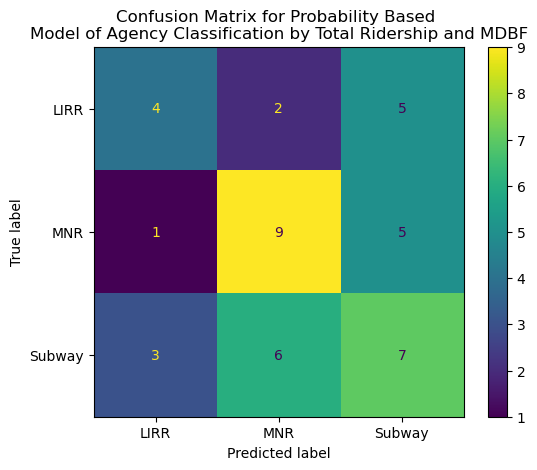

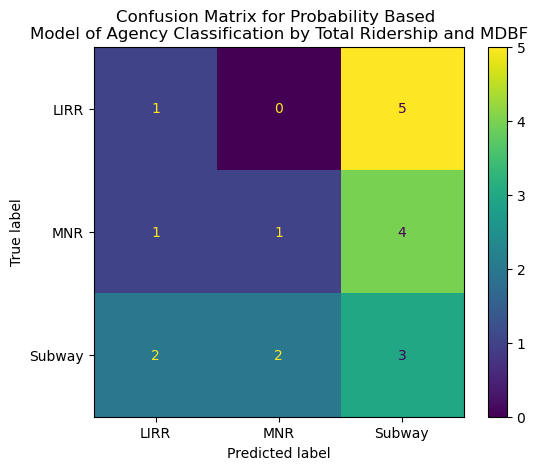

In [179]:
# Model determined by probabilities of positive and negative in the training data
# proability of negative opinion in training data set
p_mnr = y_train.value_counts()[0]/len(y_train)
p_sub = y_train.value_counts()[1]/len(y_train)
p_lirr = y_train.value_counts()[2]/len(y_train)

# Set seed for reproducibility
np.random.seed(717)

# Randomly drawn array from uniform distribution based on above probabilities that serves as a prediction
yp_train = np.random.choice(np.arange(0,3),p=[p_mnr,p_sub,p_lirr],size=len(y_train))

# Predict based on same probability for test data set
yp_test = np.random.choice(np.arange(0,3),p=[p_mnr,p_sub,p_lirr],size=len(y_test))

# Training set
cm = confusion_matrix(y_train,yp_train)
cm_plot = ConfusionMatrixDisplay(cm,display_labels=labels)
cm_plot.plot()
plt.title("Confusion Matrix for Probability Based \nModel of Agency Classification by Total Ridership and MDBF")
plt.savefig("../../501-project-website/images/DT-CONFUSION-MX-PBased-train.png")

# Test set
cm = confusion_matrix(y_test,yp_test)
cm_plot = ConfusionMatrixDisplay(cm,display_labels=labels)
cm_plot.plot()
plt.title("Confusion Matrix for Probability Based \nModel of Agency Classification by Total Ridership and MDBF")
plt.savefig("../../501-project-website/images/DT-CONFUSION-MX-PBased-test.png")

# Print classification report
print("CLASSIFICATION REPORT FOR TRAINING SET")
print(classification_report(y_train,yp_train,target_names=labels))
print("CLASSIFICATION REPORT FOR TEST SET")
print(classification_report(y_test,yp_test,target_names=labels))

## Hyperparameter Tuning

However, in order to find the most optimal decision tree model to classify agency based on various performance metrics, a set of hyperparameters (i.e., user defined inputs for the classifier method) must be chosen which will affect how well the resulting model fits the training and test data sets. For decision tree (DT) models, two important hyperparameters are the criterion and maximum depth. Criterion refers to the way that the quality of each split in the decision tree is assessed, either using the Gini impurity, or entropy. Gini impurity analyzes the frequency at which data points may be misclassified for a given split when they are randomly labelled, and its range from 0 to 0.5. When a leaf of a decision tree has a Gini impurity score of 0, that means that the leaf is pure, and no further splits should be made. Entropy is a more complex measure than Gini impurity, and it measures the extent of disorder within a target split, and the split that results in the least entropy is considered the "optimal" split. Entropy ranges from 0 to 1, and when entropy is equal to 0, that means purity is achieved within a node. The maxmimum depth of a decision tree model caps the number of layers the DT model may have, which can enable overfitting if the value is too high, and underfitting if the maximum depth is too low.

In order to aptly tune these hyperparameters to the problem of agency classification at hand, a grid search will be performed. A grid search looks at all combinations of predetermined hyperparameter options (i.e., the range of what is searched is user defined) and constructs a model, which generates various measures of accuracy. DT models of this scale are not overly computationally intensive to run, so I will iterate over the grid search 100 times to observe what maximum depth parameters and which criterion is more appropriate for the model at hand. Each grid search generates a "best estimator", or best set of parameters, which I then save to be analyzed further. The code that accomplishes this task can be found in the below dropdown.

In [180]:
# Define search parameters to be iterated over
best_max_depths = []
best_criterions = []
# Perform grid search process 100 times to account for randomness in the process
for i in range(1,101):
    search_params = {'criterion':['gini','entropy'],'max_depth':[1,2,3,4,5,6,7,8,9,10]}
    grid = GridSearchCV(DecisionTreeClassifier(),search_params,cv=5,refit=True)
    grid.fit(x_train,y_train)
    # Extract mean test scores and reshape
    scores = grid.cv_results_['mean_test_score']
    scores = np.array(scores).reshape(len(search_params['criterion']), len(search_params['max_depth']))
    # Extract best mean estimator from this iteration
    new_max_depth = grid.best_estimator_.get_params()['max_depth']
    new_criterion = grid.best_estimator_.get_params()['criterion']
    best_max_depths.append(new_max_depth)
    best_criterions.append(new_criterion)
    


Once the 100 best maximum depth parameters and 100 best criterion choices have been aggregated, they must be compared to one another to ascertain what is the most "optimal" parameter combination. Plots of the frequency of best estimators are plotted below.

     0
1    1
6   28
7   17
8   19
9   19
10  16
          0
entropy  59
gini     41


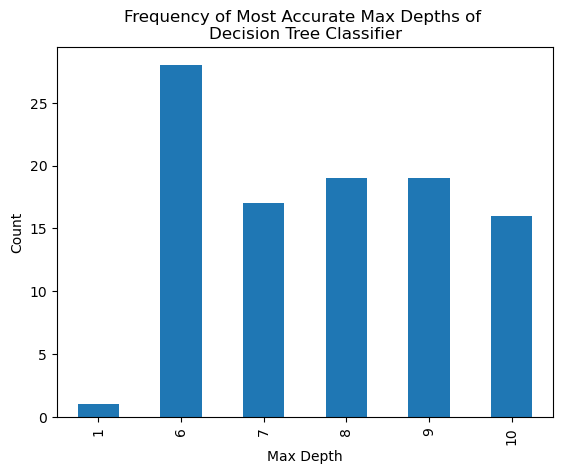

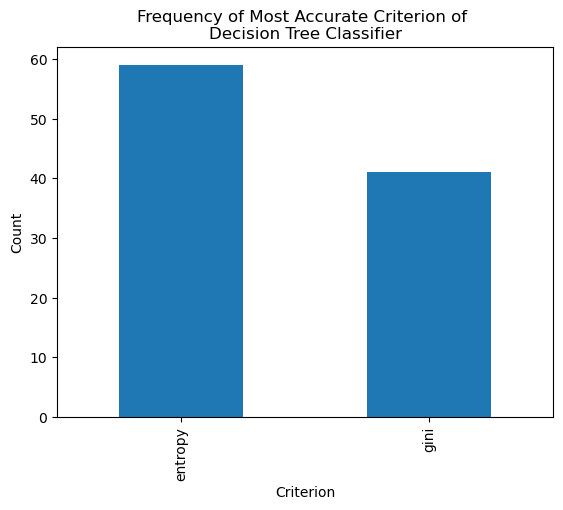

In [181]:
# Calculate counts of max depths and best criterions
count_md = Counter(best_max_depths)
count_crit = Counter(best_criterions)
count_md_df = pd.DataFrame.from_dict(count_md,orient='index')
count_md_df.sort_index(inplace=True)
count_crit_df = pd.DataFrame.from_dict(count_crit,orient='index')

# Print frequency data frames
print(count_md_df)
print(count_crit_df)

# Plot counts of best criterion
count_md_df.plot(kind='bar',legend=None)
plt.title("Frequency of Most Accurate Max Depths of \nDecision Tree Classifier")
plt.xlabel("Max Depth")
plt.ylabel("Count")
plt.show()

count_crit_df.plot(kind='bar',legend=None)
plt.title("Frequency of Most Accurate Criterion of \nDecision Tree Classifier")
plt.xlabel("Criterion")
plt.ylabel("Count")
plt.show()

# Plot counts of best max depth parameter


As can be seen above, various maximum depths were deemed "best" by the several grid searches, while the frequency of Gini and entropy criterion being deemed the "best" estimator are not too dissimilar, although there is an apparent difference. Thus, the average of all of the "best" maximum depth parameters and the greater of the "best" criterion are to be used as the basis for the final DT model.

In [182]:
# Calculate average best max depth of grid searches
max_depth_avg = sum(best_max_depths)/len(best_max_depths)

print("The ideal parameters for this model based on a grid search a maximum depth of",max_depth_avg,"with a criterion of entropy")

The ideal parameters for this model based on a grid search a maximum depth of 7.71 with a criterion of entropy


## Final Results

The process of hyperparameter tuning has generated the above "optimal" parameters to be used to construct a decision tree model to classify agency type based on the previously mentioned indicators of performance. More detailed summaries of this model are generated and explained below.

CLASSIFICATION REPORT FOR TRAINING SET
              precision    recall  f1-score   support

        LIRR       1.00      1.00      1.00        11
         MNR       1.00      1.00      1.00        15
      Subway       1.00      1.00      1.00        16

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42

CLASSIFICATION REPORT FOR TEST SET
              precision    recall  f1-score   support

        LIRR       0.62      0.83      0.71         6
         MNR       0.75      0.50      0.60         6
      Subway       1.00      1.00      1.00         7

    accuracy                           0.79        19
   macro avg       0.79      0.78      0.77        19
weighted avg       0.80      0.79      0.78        19



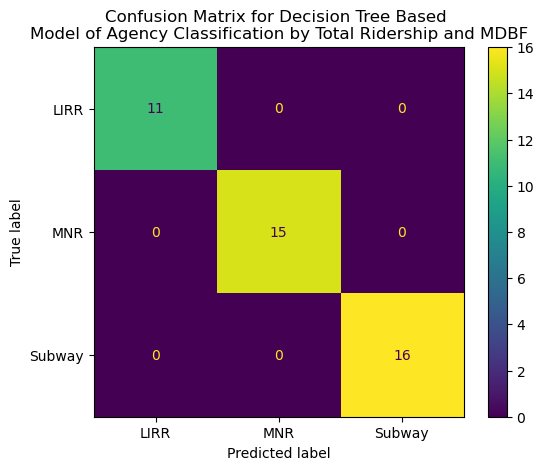

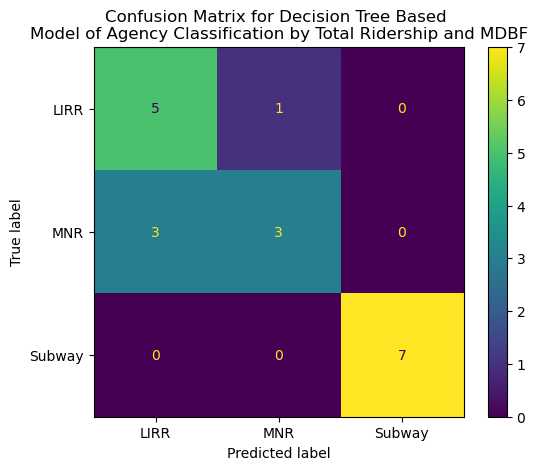

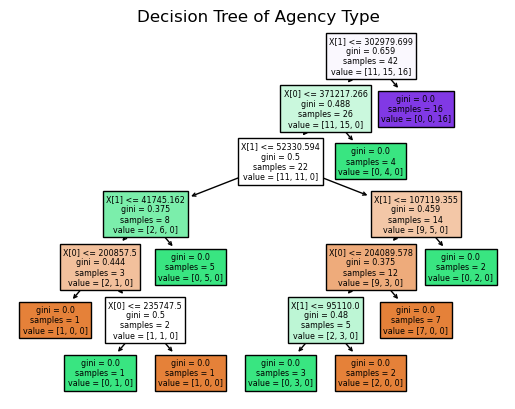

In [183]:
model = tree.DecisionTreeClassifier(max_depth=round(max_depth_avg),criterion=higher_criterion)
model = model.fit(x_train,y_train)

# Save predictions for later plot use
yp_train = model.predict(x_train)
yp_test = model.predict(x_test)

# Print classification report
print("CLASSIFICATION REPORT FOR TRAINING SET")
print(classification_report(y_train,yp_train,target_names=["LIRR","MNR","Subway"]))
print("CLASSIFICATION REPORT FOR TEST SET")
print(classification_report(y_test,yp_test,target_names=["LIRR","MNR","Subway"]))

# Calculate the confusion matrix and classification report for the train and test data.
cm = confusion_matrix(y_train,yp_train)
cm_plot = ConfusionMatrixDisplay(cm,display_labels=labels)
cm_plot.plot()
plt.title("Confusion Matrix for Decision Tree Based \nModel of Agency Classification by Total Ridership and MDBF")
plt.savefig("../../501-project-website/images/DT-CONFUSION-MX-train.png")

# Test set
cm = confusion_matrix(y_test,yp_test)
cm_plot = ConfusionMatrixDisplay(cm,display_labels=labels)
cm_plot.plot()
plt.title("Confusion Matrix for Decision Tree Based \nModel of Agency Classification by Total Ridership and MDBF")
plt.savefig("../../501-project-website/images/DT-CONFUSION-MX-test.png")

fig = plt.figure()
tree_plot = tree.plot_tree(model,filled=True)
plt.title("Decision Tree of Agency Type")
plt.show()

We can see that this decision tree is overfitted considering the perfect accuracy in predicting the training data values but poorer, albeit still decent at 80%, accuracy in predicting test data set labels, despite the hyperparameter tuning. However, despite this overfitting, it still clearly does a better job at classifying agency type compared to the random model based on the underlying agency label frequencies in the training data set. The confusion matrices reinforce this assertion, given by the perfect accuracy of the model in predicting the training data set values due to no entries off the main diagonal being 0, indicating no false positives or false negatives. The training data set is relatively small in size, with only 4 out of 19 agency labels being misidentified, along with perfect prediction of the subway agency labels. In order to improve this DT model of agency classification, a larger sample size would provide greater insight into its suitability for this problem as well as an even more thorough hyperparameter search. Additionally, more features could be analyzed (if appropriate data can be gathered) to further enhance the capabilities of this DT model.

## Conclusions

Ultimately, from the creation of the rudimentary probability-based classification model to the hyperparameter tuning and construction of the finalized SVC model, we can see that the DT model is a superior classification model compared to the probability-based model, given by the decent accuracy, precision, and recall scores along with the accompanying confusion matrices, despite the apparent overfitting. This model could be used, given performance data regarding heavy rail transit in the NYC area, predict which agency that performance data belongs to with reasonable accuracy, superior to a probability based model.

However, it is unclear whether a decision tree model is the most appropriate model for this particular problem. Further analyses could be done using other model types to investigate what type of model is the most appropriate to address this particular problem, which can then be compared to the decision tree model constructed in this section. Most important for this further investigation would be the acquisition of data with new explanatory variables that could be used to predict agency type. This would enhance this model's generalizability and scope of use given the wide variety of performance indicators that exist for heavy rail transit.